In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
sns.set(rc={'figure.figsize':(12, 4)})

In [2]:
data = pd.read_pickle("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'], format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
date = data["Date"]
data = data.set_index('Date')

data.Energy_Generated=pd.to_numeric(data.Energy_Generated)
display(data.tail())
print(len(data))

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2020-02-03,3321,3.075,2910,0,646,13:40,Fine,6,29,NaN,NaN,NaN,NaN,4048
2020-02-04,1611,1.492,1275,0,678,14:30,Mostly Cloudy,8,16,NaN,NaN,NaN,NaN,4084
2020-02-05,4140,3.833,2816,0,737,12:40,Fine,0,16,NaN,NaN,NaN,NaN,4121
2020-02-06,4241,3.927,3585,0,740,13:00,Fine,-2,20,NaN,NaN,NaN,NaN,4157
2020-02-07,2654,2.457,2337,0,740,13:00,Fine,0,21,NaN,NaN,NaN,NaN,4194


2541


In [3]:
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
train_data = data[data.index < thresh_date]
test_data = data[data.index > thresh_date]

In [4]:
data.iloc[0,:]

Energy_Generated                  1013
Efficiency                       0.938
Energy_Exported                    998
Energy_Used                          0
Peak_Power                         807
Peak_Time                        13:10
Condition                      Showers
Min_Temperature                      8
Max_Temperature                     13
Peak_Energy_Import                 NaN
Off-Peak_Energy_Import             NaN
Shoulder_Energy_Import             NaN
High-Shoulder_Energy_Import        NaN
Insolation                        3458
Name: 2013-01-01 00:00:00, dtype: object

In [5]:
weekly_data_mean = train_data.Energy_Generated.resample('W').mean().dropna()
daily_data = train_data.Energy_Generated.dropna()

In [6]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
sc = MinMaxScaler()
training_data = sc.fit_transform(daily_data.values.reshape(-1,1))

# split into samples
n_steps = 28
X, y = split_sequence(training_data, n_steps)

# summarize the data
#for i in range(len(X)):
    #print(X[i], y[i])

In [8]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(X))
dataY = Variable(torch.Tensor(y))

trainX = Variable(torch.Tensor(X[0:train_size]))
trainY = Variable(torch.Tensor(y[0:train_size]))

testX = Variable(torch.Tensor(X[train_size:len(X)]))
testY = Variable(torch.Tensor(y[train_size:len(y)]))

In [9]:
class Vanilla_LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(Vanilla_LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = n_steps
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [10]:
num_epochs = 1000
learning_rate = 0.01

input_size  = 1
hidden_size = 2
num_layers  = 1

num_classes = 1

lstm = Vanilla_LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []
val_loss_list = []
# Train the model
for epoch in range(num_epochs):
    lstm.train()
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    
    ## Validation step
    lstm.eval()
    test_predict = lstm(testX)
    val_loss = criterion(test_predict, testY)  
    
    loss_list.append(loss)
    val_loss_list.append(val_loss)

    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, loss.item(), val_loss.item()))

Epoch: 0, loss: 0.26432, val_loss: 0.18036
Epoch: 100, loss: 0.06148, val_loss: 0.05976
Epoch: 200, loss: 0.05645, val_loss: 0.05119
Epoch: 300, loss: 0.05511, val_loss: 0.04943
Epoch: 400, loss: 0.05455, val_loss: 0.04846
Epoch: 500, loss: 0.05443, val_loss: 0.04819
Epoch: 600, loss: 0.05436, val_loss: 0.04810
Epoch: 700, loss: 0.05431, val_loss: 0.04804
Epoch: 800, loss: 0.05427, val_loss: 0.04800
Epoch: 900, loss: 0.05423, val_loss: 0.04797


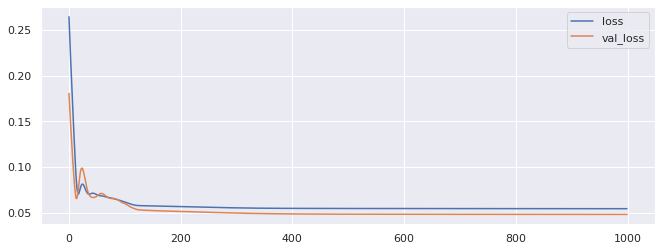

In [11]:
plt.plot(loss_list[:], label="loss")
plt.plot(val_loss_list[:], label="val_loss")
plt.legend()
plt.show()

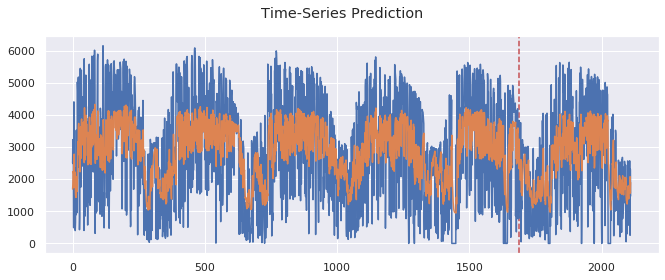

In [13]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(data_predict[len(trainX):], dataY_plot[len(trainX):],squared=False)
print("RMSE = %d" % rmse) 

RMSE = 1350


mean = 19.340038
std  = 1419.6074


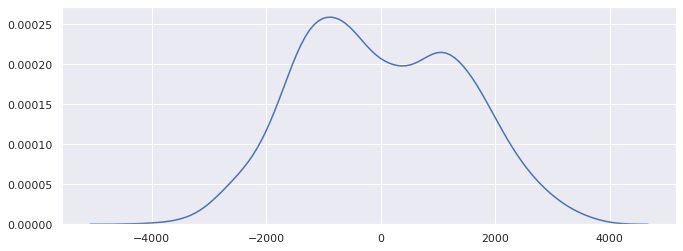

In [15]:
residuals = (data_predict - dataY_plot).flatten()
#plt.plot(residuals)
sns.kdeplot(residuals)
print("mean =", np.mean(residuals))
print("std  =", np.std(residuals))

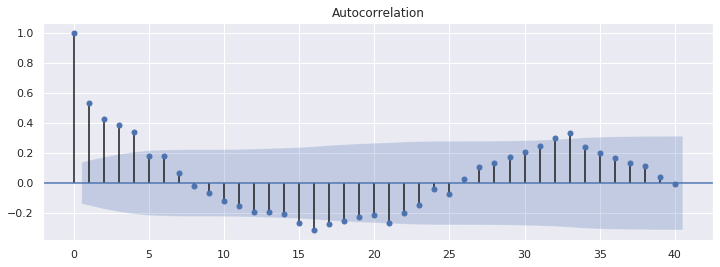

In [41]:
import statsmodels.api as sm 
acf = sm.graphics.tsa.plot_acf(residuals, lags=40)

**MV LSTM**

In [17]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [37]:
#daily_data_with_weather = train_data[['Condition','Min_Temperature','Max_Temperature','Energy_Generated']]
daily_data_with_weather = train_data[['Condition','Energy_Generated']]
conditions = set(daily_data_with_weather['Condition'])

encoder = LabelEncoder()
daily_data_with_weather.iloc[:,0] = encoder.fit_transform(daily_data_with_weather.iloc[:,0])
conditions_labels = set(daily_data_with_weather['Condition'])
print(conditions, "\n", conditions_labels)

# ensure all data is float
daily_data_with_weather = daily_data_with_weather.astype('float32')

#daily_data_with_weather['Energy_Generated_x'] = daily_data_with_weather.Energy_Generated.shift(1)
daily_data_with_weather['Energy_Generated_x'] = daily_data_with_weather.Energy_Generated
daily_data_with_weather = daily_data_with_weather.dropna()
cols = daily_data_with_weather.columns.tolist()
cols = cols[-1:] + cols[:-1]
daily_data_with_weather = daily_data_with_weather[cols]
print(daily_data_with_weather.columns.values)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(daily_data_with_weather)
print(daily_data_with_weather.tail())

{'Partly Cloudy', 'Not Sure', 'Fine', 'Mostly Cloudy', 'Showers', 'Cloudy'} 
 {0, 1, 2, 3, 4, 5}
['Energy_Generated_x' 'Condition' 'Energy_Generated']
            Energy_Generated_x  Condition  Energy_Generated
Date                                                       
2018-12-26              2579.0        1.0            2579.0
2018-12-27              2572.0        1.0            2572.0
2018-12-28               254.0        5.0             254.0
2018-12-29              2314.0        1.0            2314.0
2018-12-30              1478.0        4.0            1478.0


/home/cynthia/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
# not the same as split_sequence (without s) function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [20]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 28 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(scaled, n_timesteps)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)

train_episodes = 350
batch_size = 16

In [21]:
### Pbm here : train/test set defined after features normalization ?
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(X))
dataY = Variable(torch.Tensor(y))

trainX = Variable(torch.Tensor(X[0:train_size]))
trainY = Variable(torch.Tensor(y[0:train_size]))

testX = Variable(torch.Tensor(X[train_size:len(X)]))
testY = Variable(torch.Tensor(y[train_size:len(y)]))

In [22]:
loss_values = []
val_loss_values = []
for t in range(train_episodes):
    mv_net.train()
    for b in range(0,len(trainX),batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainY[b:b+batch_size]    

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
        
    
    loss_values.append(loss)
        
    ##add test
    mv_net.eval()
    mv_net.init_hidden(testX.size(0))
    test_predict = mv_net(testX)
    loss = criterion(test_predict.view(-1), testY)  
    val_loss_values.append(loss)
    if t % 10 == 0:
        print("%d, loss %f val_loss %f" % (t,loss_values[-1],loss))   

/home/cynthia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/cynthia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


0, loss 0.044823 val_loss 0.059519
10, loss 0.008459 val_loss 0.005406
20, loss 0.000541 val_loss 0.001866
30, loss 0.000607 val_loss 0.001520
40, loss 0.013453 val_loss 0.009474
50, loss 0.003837 val_loss 0.007100
60, loss 0.000907 val_loss 0.003088
70, loss 0.010997 val_loss 0.012315
80, loss 0.007490 val_loss 0.010917
90, loss 0.008701 val_loss 0.008077
100, loss 0.003164 val_loss 0.011371
110, loss 0.006501 val_loss 0.012359
120, loss 0.014320 val_loss 0.010695
130, loss 0.000983 val_loss 0.000657
140, loss 0.007613 val_loss 0.015537
150, loss 0.004987 val_loss 0.013367
160, loss 0.011533 val_loss 0.010603
170, loss 0.007780 val_loss 0.007747
180, loss 0.005864 val_loss 0.006388
190, loss 0.006537 val_loss 0.010640
200, loss 0.010839 val_loss 0.010447
210, loss 0.006788 val_loss 0.009390
220, loss 0.005602 val_loss 0.006804
230, loss 0.010495 val_loss 0.006930
240, loss 0.007919 val_loss 0.010492
250, loss 0.004965 val_loss 0.007249
260, loss 0.011083 val_loss 0.010538
270, loss 0.

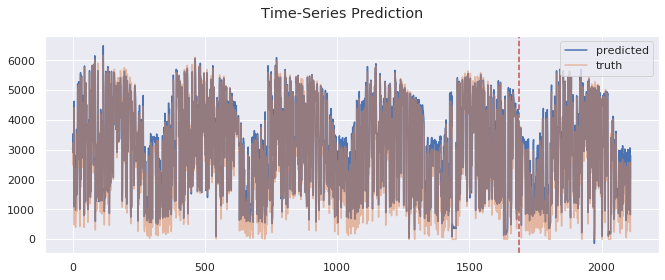

In [35]:
mv_net.eval()
mv_net.init_hidden(dataX.size(0))
train_predict = mv_net(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = np.c_[ data_predict, np.zeros(dataY_plot.shape[0]) ]
data_predict = np.c_[ data_predict, dataY_plot ]

data_predict = scaler.inverse_transform(data_predict)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(data_predict[:,0], label="predicted")
plt.plot(data_predict[:,2], alpha=0.5, label="truth")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

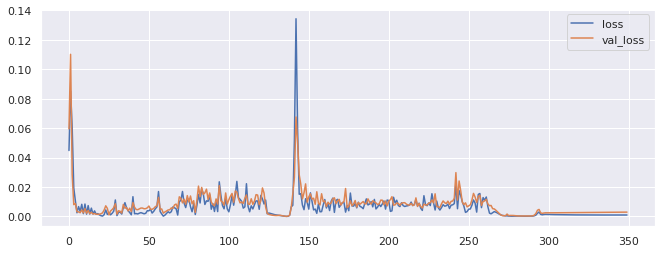

In [31]:
plt.plot(loss_values[:], label="loss")
plt.plot(val_loss_values[:], label="val_loss")
plt.legend()
plt.show()

In [32]:
rmse = mean_squared_error(data_predict[len(testX):,2], data_predict[len(testX):,0],squared=False)
print("RMSE = %d" % rmse) 

RMSE = 283


mean = -212.46327504032263
std  = 188.78372058181296


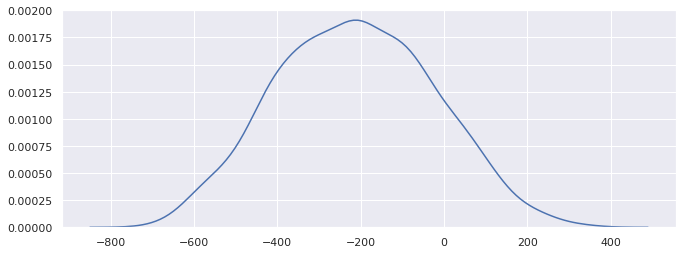

In [33]:
residuals = data_predict[:,2] - data_predict[:,0]
sns.kdeplot(residuals)
print("mean =", np.mean(residuals))
print("std  =", np.std(residuals))

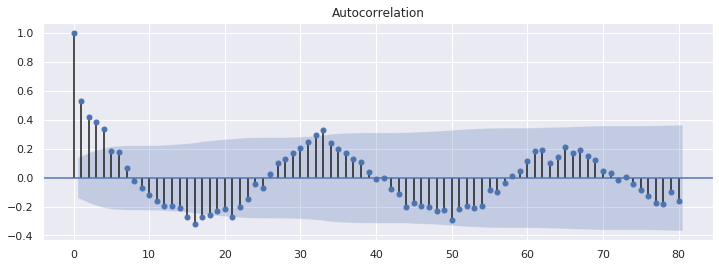

In [42]:
acf = sm.graphics.tsa.plot_acf(residuals, lags=80)

Total RMSE = 193 

Partly Cloudy (285) : 
	 RMSE = 190, r_mean = 51 
Not Sure (902) : 
	 RMSE = 213, r_mean = 94 (non-normal)
Fine (285) : 
	 RMSE = 204, r_mean = 90 
Mostly Cloudy (49) : 
	 RMSE = 105, r_mean = -17 
Showers (392) : 
	 RMSE = 198, r_mean = 76 
Cloudy (198) : 
	 RMSE = 178, r_mean = -30 (non-normal)


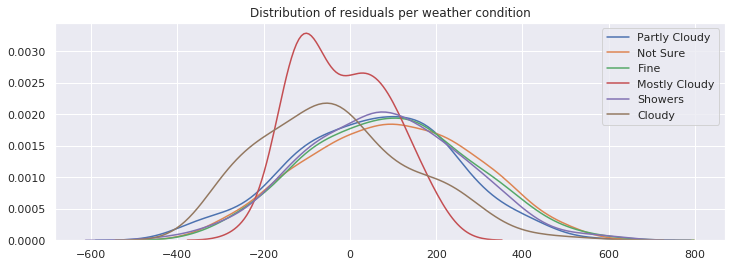

In [40]:
from scipy import stats
alpha = 0.05

df = daily_data_with_weather.copy()
df = df.iloc[n_timesteps:]
df = df.reset_index()

print("Total RMSE = %d \n" % rmse) 

for c, c_label in zip(conditions, conditions_labels):
    # Select indices corresponding to condition
    condition_indices = df[df['Condition']==c_label].index.values
    target = [data_predict[:,2][i] for i in condition_indices]
    predicted = [data_predict[:,0][i] for i in condition_indices]
       
    # Study residuals
    residuals = np.array(target) - np.array(predicted)
    sns.kdeplot(residuals, label=c)
    c_residual_mean = np.mean(residuals)
    k2, p  = stats.normaltest(residuals)
    normal = "(non-normal)" if p < alpha else ""
    
    # Compute rmse score
    c_rmse = mean_squared_error(target,predicted,squared=False)
    
    print("%s (%d) : \n\t RMSE = %d, r_mean = %d %s" % (c, len(condition_indices), c_rmse, c_residual_mean, normal)) 

    
plt.legend()
plt.title("Distribution of residuals per weather condition")
plt.show()